## PH21 Assignment 5

In [1]:
######################################################
#                                                    #
#  Do not commit cache/data files to the repository  #
#                                                    #
######################################################

### In this assignment, you will need to do the following:

1. Determine the error bars on event count datasets
2. Use a collection of events to statistically test if a particle exists given a data channel
3. Fit a model of the particle and background events. Then test against a model with only the background events
3. Determine the likelihood that a particle exists using the errorbars generated from the event dataset.


Background
===========
In the previous assignments (including some of ph20) we have manipulated and fit against datasets where we have either ignored errorbars or had them given to us. Here we must determine the statistical error, given typical "counting statistics" present in all manner of physics experiments, though perhaps most prominently in High Energy Physics experiments using particle colliders.

motivating literature:

If you are interested in some recent discoveries, take a look at the discovery of tetraquarks from LHCb: https://www.nature.com/articles/s41567-022-01614-y and its figure data at https://www.hepdata.net/record/114871. 

The figure to stare at is https://www.nature.com/articles/s41567-022-01614-y/figures/1.

similarly, look at a recent discovery of a Higgs boson decay channel through Z-gamma decays, https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.132.021803. There, look at Figure 2 https://journals.aps.org/prl/article/10.1103/PhysRevLett.132.021803/figures/2/medium. A more complete history of the Higgs detection and characterization is given in https://pdg.lbl.gov/2022/reviews/rpp2022-rev-higgs-boson.pdf, which has many more similar plots. This background is interesting, but not essential for the assignment.

What do these analysis have in common? The datasets are essentially plotting a Probability Distribution of event decays. What does that mean? Well a collider only sees the results of a collition as a big collection of resulting particles, their energy and their momentum (via where in the detector they were sensed). From data about the particles detected, various analysis methods "reconstruct" intermediate particles that led to the final observations. 

In the first paper, those intermediate observations were D- and Pi- Mesons. In the second paper, those were a pair of Z-boson and gamma (photon) particles. In both, the total energy of those particular choices of intermediate particles is plotted against the *rate* that events at that energy is seen. New particles tend to create an excess of events at an energy corresponding to the mass of the particle. The trick is to determine what choice of final emission particles best detects the interesting but short-lived intermediate (e.g. a Higgs boson or tetraquark) . We will assume those things, and just try to perform the detection, given a set of particle event data on the final emission states.

OK.... so how is that done? Well once those particles were reconstructed, essentially they were just put into a big histogram over the total energy of the resulting particles. By using simulation tools, the histograms for Higgs vs. No-higgs or tetra vs. no-tetra could be determined. 

With the data histogrammed, it then becomes a hypothesis test to determine which reality is the most likely. Likelihood is a statistical way of saying "in which reality is the observed data more probable."  

We will explore this using some simple examples, before looking at a dataset that mimics this Higgs channel discovery. I call it a mimic of the discovery since the Higgs was already discovered prior to this paper, but this newer result is a particularly clean example. 

In [2]:
# note, this intro notebook is using some new packages
# polars, which provides dataframes like pandas but is newer and faster. You don't need to know it for the assignment! numpy and matplotlib are sufficient
# these examples will also use altair and vegafusion for visualization. This is to make them interactive, to get a sense of what the data look like
# you DO NOT need to use vega altair in the assignment

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import scipy as sp
#import mplhep as hep
import h5py as h5
import altair as alt
import polars as pl
import vegafusion as vf

# these can be installed in conda using
# conda -c conda-forge polars
# conda -c conda-forge altair pyarrow vegafusion vegafusion-python-embed vl-convert-python

# note that polars is compiled, and it may only work if run from a compatibility compile (this is needed on VMs)
# pip install polars-lts-cpu # see https://pypi.org/project/polars-lts-cpu/


# Detecting a loaded coin

The first foray into this kind of statistics is to detect a loaded coin. What if we flip a coin some number of times. How many times do we need to flip it to detect if it is not 50:50?

In [3]:
#============== Generate fake coin flips - Do not change this cell ==============#

rng = np.random.default_rng(42)

prob = 0.5

coin_flip = rng.choice([0,1], size=100, p = [prob, 1-prob])

df = pl.DataFrame({
   'coin' : coin_flip
})
df_model = pl.DataFrame({
   'coin' : [prob]
}) 

coin_flip

array([1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1])

That's simple enough, let's look at its sum and determine the average

In [4]:
mean = sum(coin_flip) / len(coin_flip)
mean

0.47

Ok, it isn't exactly the average we were expecting of course, as it is a random variable. The sum of such numbers forms a *binomial distribution* https://numpy.org/doc/stable/reference/random/generated/numpy.random.binomial.html, https://en.wikipedia.org/wiki/Binomial_distribution . Using N=len(coin_flip), the sum is N * prob and a variance of the sum is N*prop*(1-prob). This means that the *relative error* of the measurement of the mean is then $\sqrt{\text{Var}} / \text{sum} = \sqrt{\frac{1-p}{N p}}$ Notably though, the factor $Np$ is simply the expected number of data points in the bin. Also note! When the probability is *small*, the 1-p term goes away.

For data, if a model exists, one can use the model to determine the expected number of data points in each bin. If a model doesn't exists, one can determine the errorbars by using the number of points actually found in the bin. This approximation doesn't work well when the number of events in a bin is very low.

In this case, we determine that the relative error of our data is

In [5]:
relerr_data = (1 - mean) / sum(coin_flip)**0.5
relerr_model = (1 - prob) / (prob * len(coin_flip))**0.5
print("Relative error of data: ", relerr_data)
print("Relative error from model: ", relerr_model)

# these are close because we had a lot of flips

Relative error of data:  0.07730844549388412
Relative error from model:  0.07071067811865475


In [6]:
# here I am using vega altair to plot. The interactivity isn't so useful here, but is nice for the later examples
# note that altair can perform computations on the data from within the plot, so I'm hiding some of the math for you to figure out.

chart_base = alt.Chart(df)
# create a bar chart with the existing coin flip data and its mean calculated
chart_bar = chart_base.mark_bar().encode(
    alt.Y('mean(coin):Q').scale(domain=(0, 1)),
).interactive()

# create a dataframe with a set of models and their error bars.
df_model = pl.DataFrame({
   'prob' : [prob, 0.25, 0.75]
}) 
df_model = df_model.with_columns(
    (((1 - pl.col('prob')) / len(df))**0.5).alias('rel_error')
)
chart_rule = alt.Chart(df_model).mark_rule().encode(
    y='prob', 
    size=alt.value(2), 
    color='prob:N',
) + alt.Chart(df_model).mark_errorbar().encode(
    y='prob',
    yError='rel_error',
).interactive()

# this is using altair to plot, which is very different than Matplotlib, but more modern for visualizations, and supports various forms of (offline) interactivity.
(chart_bar + chart_rule)

#you can drag it around, neat..
# this example shows that the model and its assumed arror are only consisent with a 50:50 split, but we can't actually resolve that close to 50:50 with the limited amount of data available

alt.LayerChart(...)

Alternatively, we can use the data itself to calculate the error bars.

In [7]:
# note, all of the transforms applied here could be done directly in Pandas or Polars. They are done here since it can make it possible to do adaptive scaling for future examples
# it might be useful to show how to do these transforms directly in Polars, but it might give away much of the assignment.
chart_base = alt.Chart(df).transform_lookup(
    lookup='coin',
    from_=alt.LookupData(
        pl.DataFrame({'coin':[0,1], 'face':['tails', 'heads']}),
        key='coin',
        fields=['face']
    ),
).transform_aggregate(
    count='count()',
    groupby=['face']
).transform_joinaggregate(
    sum = 'sum(count)'
).transform_calculate(
    abserr = (alt.datum.count)**0.5,
    rel = (alt.datum.count / alt.datum.sum),
    relerr = (alt.datum.abserr / alt.datum.sum),
)
# create a bar chart with the existing coin flip data and its mean calculated
chart_bar = chart_base.mark_bar().encode(
    alt.Y('count:Q').scale(),
    alt.X('face:N'),
).interactive() + chart_base.mark_errorbar().encode(
    x='face:N',
    y='count:Q',
    yError='abserr',
).interactive()

chart_bar_rel = chart_base.mark_bar().encode(
    alt.Y('rel:Q').scale(),
    alt.X('face:N'),
).interactive() + chart_base.mark_errorbar().encode(
    x='face:N',
    y='rel:Q',
    yError='relerr',
).interactive()

# create a dataframe with a set of models and their error bars.
df_model = pl.DataFrame({
   'coin' : [prob, 0.25, 0.75]
}) 
chart_rule = alt.Chart(df_model).mark_rule().encode(
    y='coin', 
    size=alt.value(2), 
    color=alt.value('red')
) 

#display(vf.transformed_data(chart_bar))
(chart_bar | chart_bar_rel + chart_rule)

# here the error bars are computed from the counts, then the data and error bars are scaled to compare to the model

alt.HConcatChart(...)

# HEP Physics

Now, the goal is to determine the rate that some events are caused as a *density*, which means that in any small interval of some space, there is some rate that events will be created. That rate can be considered as a fraction of the overall number of events, with the goal of determining the fraction in any/every interval as best as possible from the data. For example, in a particle physics experiments the goal is to determine the scattering rate of particles into various kinds of channels, where only the final particles and their energies are measured in the end.

If we measure just one emitted particle and its energy, then it might have a distribution function that looks like a Lorentzian resonance

$P(E) = \frac{\Delta E^2}{\Delta E^2 + (E - mc^2)^2}$ with rate 

where $\Delta E$ is the energy uncertainty of an intermediate particle, related to its lifetime before it decays. $m$ is the mass of the intermediate particle state to detect. Finally, the rate can be determined as:

$R(E) = I \cdot T \cdot P(E)$

where I is an intensity in collissions/sec and T is the integration time, so the product is the total number of collission events in the observation channel.

Practically, the detector is only going to measure a long list of particle events. Below we plot the distributions (using matplotlib)

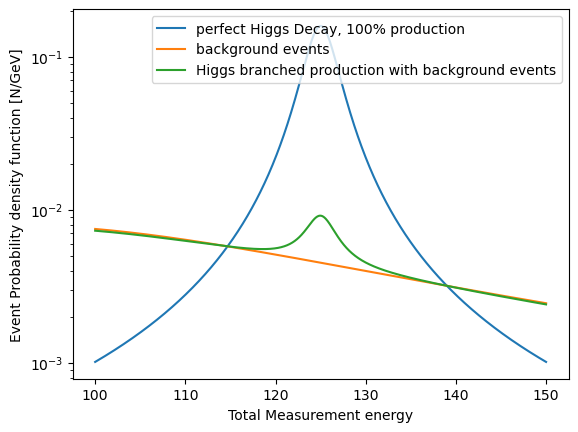

In [8]:
def P_Higgs_test(E_GeV, DeltaE_GeV=2):
    # masses in GeV
    # Delta_E is the energy resolution (or, the mass-uncertainty/lifetime of the Higgs, but that is narrow comparted to the energy resolution)
    E_m = 125
    return DeltaE_GeV / (DeltaE_GeV**2 + (E - E_m)**2) / np.pi

def P_Higgs_background(E_GeV):
    # masses in GeV
    # Delta_E is the energy resolution (or, the mass-uncertainty/lifetime of the Higgs, but that is narrow comparted to the energy resolution)
    E_m = 90 # some example masses and widths
    DeltaE_GeV = 40
    return DeltaE_GeV / (DeltaE_GeV**2 + (E - E_m)**2) / np.pi

# here we factor in a branching ratio, which represents what fraction of events are background processes, vs what fraction become our interesting particle.

BR = 3e-2 # we assume a model where 3% of events become a Higgs-like particle
def P_Higgs_and_BG(E):
    return P_Higgs_test(E) * BR + (1-BR)*P_Higgs_background(E)

fig, ax = plt.subplots()
E = np.linspace(100, 150, 1000)
ax.plot(E, P_Higgs_test(E), label='perfect Higgs Decay, 100% production')
ax.plot(E, P_Higgs_background(E), label='background events')
ax.semilogy(E, P_Higgs_and_BG(E), label='Higgs branched production with background events')

ax.set_ylabel('Event Probability density function [N/GeV]')
ax.set_xlabel('Total Measurement energy')
ax.legend()

The above plot represents the detection of a particle like the Higgs, where the scattering process produces the Higgs and then it decays to e.g. photons, which are measured in a detector that can resolve their energy (usign something like a Calorimeter).

Note! The data plotted is a probability density, but only part of the domain is plotted, so it wont sum to a probability of 1. We are only seeing the probability conditioned to being within the window that we are looking. This is important for normalizing event rates!

The proton-proton collissions also produce a lot more than just the Higgs that we are interested in. In fact the majority of what is produced is non-Higgs. This is represented by a "branching ratio" weights between production of the background processes with the production of the main process.

The goal of this assignment is to distinguish the main event process from the background process, given that the data only arrives as a set of events

In [9]:
P_dist = P_Higgs_test(E) * BR + (1-BR)*P_Higgs_background(E)

# here we condition the probabity on only looking within our particular event window
P_dist = P_dist/np.sum(P_dist)
N_events = 3000
events = np.random.choice(E, size=N_events, p=P_dist)
events

df = pl.DataFrame({
   'event_GeVs' : events,
   'event_num': np.arange(len(events))
})
df

event_GeVs,event_num
f64,i64
124.124124,0
108.708709,1
119.469469,2
143.343343,3
129.429429,4
127.827828,5
102.452452,6
123.823824,7
107.857858,8


In [10]:
alt.data_transformers.disable_max_rows()

bind_binning = alt.binding_range(min=0.1, max=10, name='Binning Resolution [GeV]:  ')
param_width = alt.param(bind=bind_binning, name='resolution',value=0.5)

bind_num = alt.binding_range(min=500, max=len(df), name='Number of Events:  ')
param_num = alt.param(bind=bind_num, name='num',value=1000)

lowest_E = 100
chart = alt.Chart(df).mark_bar().encode(
    alt.X("binned_GeVs:Q").scale(domain=(100, 150)),
    y='count()',
).add_params(param_num).add_params(param_width).transform_filter(
    alt.datum.event_num < param_num,
).transform_calculate(
    binned_GeVs=alt.expr.floor((alt.datum.event_GeVs-lowest_E) / param_width) * param_width + lowest_E + param_width/2
).properties(width=1000)
chart

# below is an adjustable histogram of the events. This uses Altair to process the data into a histogram, which it can do interactively. We haven't yet put on the error bars, or computed the effective event rate.

alt.Chart(...)

the goal for this assignment is to get a dataset array, then use histogram and binning routines to get the event rate. Then calculate the error bars from the event numbers in each bin. Finally, convert the event count model (and error bars) back into physical rate units.

The above plot shows how the event counts will look and scale as you adjust the detection number and the binning. The errorbars should be consistent with the random distribution.

Now open this example plot in your browser (this link make not work from a running notebook)
[Example Plot of Data with Errorbar](./errorbar_model_view.html)